# Preprocesado de las noticias

Pre-procesado para eliminar URLS, símbolos. Es decir, cosas que no son palabras

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Nicer style
style.use('seaborn') 

In [2]:
import re #regexp

Tokenizer de NLTK (Natural Language Tool Kit) basado en expresiones regulares.

In [3]:
from nltk.tokenize import RegexpTokenizer

### Limpieza del dataset
Cargamos el dataset de noticias

In [14]:
news = pd.read_csv("../data/news_cleaned_2018_02_13.csv", nrows=50_000)

news = news[['type', 'content', 'title']]

#Remove columns with NaNs 
news = news.dropna()

In [15]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

Limpiamos los campos que usaremos: Título y contenido

In [16]:
#Clean content
news['content'] = news.apply(lambda row: clean_text(row['content']), axis=1)
#Clean title
news['title'] = news.apply(lambda row: clean_text(row['title']), axis=1)

#Select only news with text
news = news[news['title'].str.len() >= 1]
news = news[news['content'].str.len() >= 1]

In [17]:
news.head(3)

,type,content,title
0,rumor,"[Life, is, an, illusion, at, least, on, a, qua...","[Is, life, an, ILLUSION, Researchers, prove, d..."
1,hate,"[Unfortunately, he, hasn, yet, attacked, her, ...","[Donald, Trump]"
2,hate,"[The, Los, Angeles, Police, Department, has, b...","[Donald, Trump]"


Las noticias están organizadas en las siguientes categorías

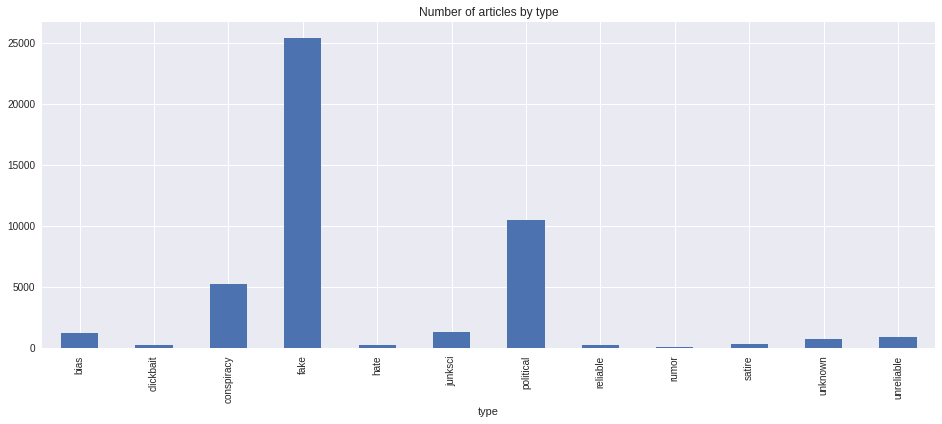

In [18]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

De aquí, y en base a las descripciones de [OpenSources](http://www.opensources.co) (de donde se han sacado las etiquetas del dataset) podemos agrupar varias categorías. Por ejemplo:
   * **Fake**
       * conspiracy
       * junksci
       * rumor
       * unknown
       * satire
       * hate
       * bias
       * unreliable
       * fake
   * **Truth**
       * reliable
       * political
   * **Clickbait**
       * clickbait

Convertimos los grupos en los nuevos.

In [19]:
def convert_tag(tag):
    """Convierte un tag a uno de tres grupos (fake, truth, clickbait)"""
    new_tag = None
    fake = set(['conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'bias', 'unreliable', 'fake'])
    truth = set(['reliable', 'political'])
    click = set(['clickbait'])
    
    if tag in fake:
        new_tag = 'fake'
    if tag in truth:
        new_tag = 'truth'
    if tag in click:
        new_tag = 'click'
        
    return new_tag

In [20]:
news['type'] = news.apply(lambda row: convert_tag(row['type']), axis=1)

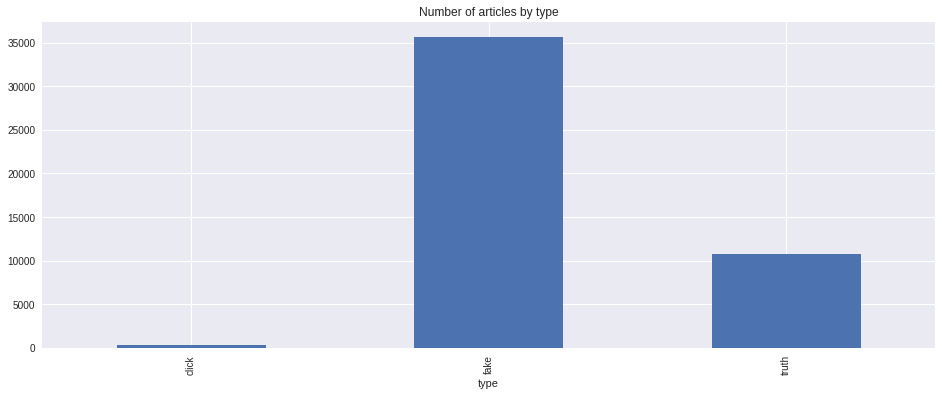

In [21]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [22]:
#Save memory
#news['type'] = news.type.astype('category')
#news.info(memory_usage='deep')

### Word2Vec

In [23]:
from gensim.models import KeyedVectors

Cargamos los vectores de un modelo entrenado por Google con los textos de millones de noticias

In [24]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True,
                                          limit=50000)

Un ejemplo de predicción de palabras similares a "Trump"

In [15]:
model.most_similar("Trump")

[('Donald_Trump', 0.8103920817375183),
 ('Apprentice', 0.47915542125701904),
 ('Paladino', 0.4655587077140808),
 ('Snooki', 0.4468839764595032),
 ('Harrah', 0.44451743364334106),
 ('MGM_Mirage', 0.44225355982780457),
 ('Vince_McMahon', 0.44097137451171875),
 ('Limbaugh', 0.4399239420890808),
 ('Palin', 0.43837088346481323),
 ('Giuliani', 0.4358449876308441)]

~~A continuación convertimos las palabras del título y contenido de las noticias en vectores numéricos para poder pasárselos a una red neuronal.~~

A continuación convertimos las palabras del título y contenido de las noticias a los índices del vocabulario de Word2Vec.

In [25]:
news['title'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['title'] if x in model.vocab], axis=1)

100%|██████████| 46663/46663 [00:01<00:00, 35555.22it/s]


In [26]:
news['content'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['content'] if x in model.vocab], axis=1)

100%|██████████| 46663/46663 [00:07<00:00, 6417.87it/s]


In [27]:
news.head(3)

,type,content,title
0,fake,"[2458, 4, 27, 17625, 12, 328, 5, 25587, 416, 1...","[1732, 258, 27, 7196, 2154, 4192, 88, 43, 13, ..."
1,fake,"[3836, 22, 506, 3059, 67, 2, 2941, 2429, 33, 3...","[6117, 13034]"
2,fake,"[7, 37481, 39852, 483, 423, 24, 42, 1837, 81, ...","[6117, 13034]"


In [28]:
len(news['content'][0])

113

Eliminar los artículos que no tengan título (Word2Vec no tenía las palabras originales)

In [29]:
news = news[news['title'].map(len) >= 1]

Pero hay un **problema**: La entrada de la red no puede ser variable. Para solucionar esto, es necesario añadir padding a todas las matrices, de tal manera que todas tengan una longitud física.

Si miden menos de una cierta longitud $n$ ($l < n$) entonces se le añadirán "filas" con ceros hasta alacanzar las dimensiones necesarias. Si mide más, se truncará de tal manera que $l = n$

In [30]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array
    

Es necesario encontrar un `token_len` que sea suficiente para que cubra, en general, la longitud de todos los artículos.

100%|██████████| 45960/45960 [00:00<00:00, 65414.93it/s]


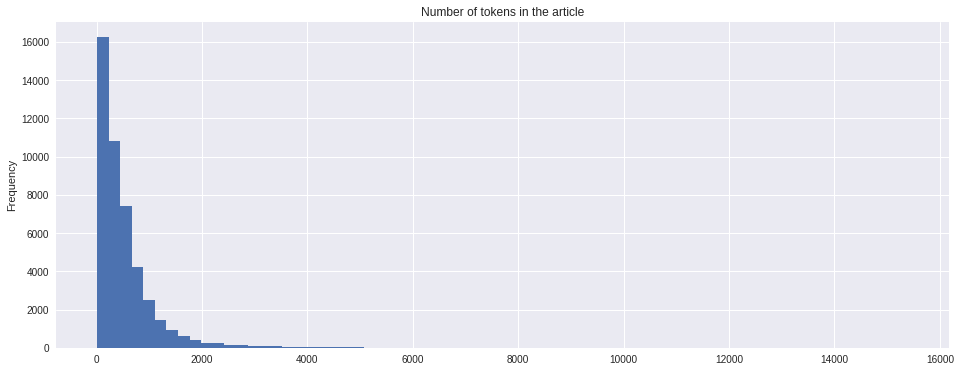

In [31]:
# Longitud en tokens de cada noticia
tokens_numbers = news.progress_apply(lambda row: len(row['content']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [32]:
print("Número medio de tokens por artículo: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por artículo: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por artículo: {}".format(int(np.median(tokens_numbers))))

Número medio de tokens por artículo: 521
Desviación estándar de tokens por artículo: 672
Mediana de tokens por artículo: 353


Escogemos el número máximo como $mean + 2\sigma$

In [33]:
max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

Ventana de tokens escogida: 1866 - Cubre el 96.76022628372498% del dataset


In [34]:
n_tokens = max_tokens

In [35]:
news['content'] = news.progress_apply(lambda r: pad_array(r['content'], n_tokens) , axis=1)

100%|██████████| 45960/45960 [00:01<00:00, 29514.51it/s]


Lo mismo para los títulos

Número medio de tokens por título: 6
Desviación estándar de tokens por título: 3
Mediana de tokens por título: 7
Ventana de tokens escogida: 14 - Cubre el 96.47302001740644% del dataset


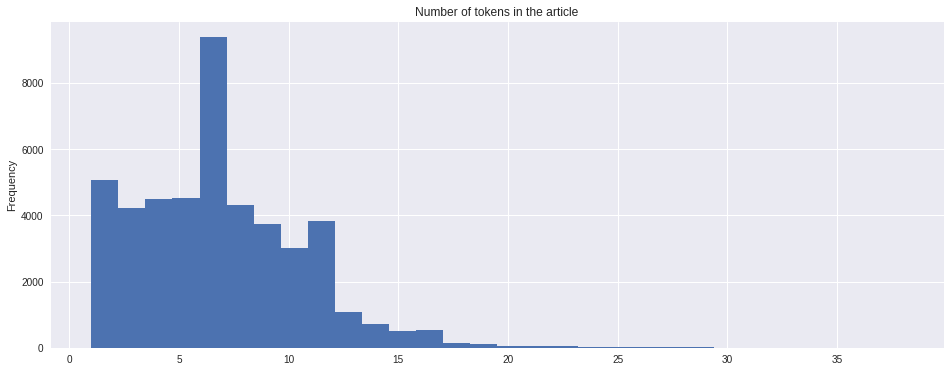

In [36]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['title']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Número medio de tokens por título: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por título: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por título: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = max_tokens

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

In [37]:
news['title'] = news.progress_apply(lambda r: pad_array(r['title'], n_tokens) , axis=1)

100%|██████████| 45960/45960 [00:00<00:00, 63971.23it/s]


### Convertir variable objetivo a OneHot Encodding

In [38]:
encoder = LabelBinarizer().fit(list(news['type']))
news['one_hot_label'] = news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

In [39]:
news.head()

,type,content,title,one_hot_label
0,fake,"[2458, 4, 27, 17625, 12, 328, 5, 25587, 416, 1...","[1732, 258, 27, 7196, 2154, 4192, 88, 43, 13, ...","[0, 1, 0]"
1,fake,"[3836, 22, 506, 3059, 67, 2, 2941, 2429, 33, 3...","[6117, 13034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0]"
2,fake,"[7, 37481, 39852, 483, 423, 24, 42, 1837, 81, ...","[6117, 13034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0]"
3,fake,"[7, 1790, 659, 24, 846, 6786, 5428, 17, 52, 44...","[13341, 1421, 1992, 1178, 8704, 11, 13034, 387...","[0, 1, 0]"
4,fake,"[59, 24, 216, 529, 104, 11, 34925, 133, 31, 24...","[13034, 43, 39049, 43, 76, 1588, 38, 23, 8158,...","[0, 1, 0]"


In [40]:
news.to_pickle('../data/news_proc.pickle')

In [62]:
news.to_csv('../data/news_proc.csv')

In [46]:
model.vocab['doing'].index

500

In [57]:
model.index2word[500]

'doing'

Guardamos el dataset procesado como `.pickle` (serializado de objetos python).

In [ ]:
news.to_pickle("../data/news_processed.pickle")